# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import os

### Torch vorbereiten

In [10]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## Hintergrundinformationen zu Adversarial Attacks

Adversarial Attacks (Feindliche oder bösartige Angriffe) sind gezielte und meist kleine Veränderungen an Eingabedaten ,z.B. Bildern, die ein Modell zu einer falschen Vorhersage bringen sollen. Für Menschen wirken diese Veränderungen oft unsichtbar oder harmlos, für ein neuronales Netz können sie jedoch entscheidend sein. Diese gezielt veränderten Daten heissen **Adversarial Samples**.
Modelle treffen Entscheidungen auf Basis von Mustern in den Daten. Adversarial Samples zeigen, dass diese Muster empfindlich gegenüber minimalen Störungen sein können. In sicherheitskritischen Anwendungen (z.B. Medizin, Verkehr, Sicherheitssysteme) kann dies zu gefährlichen Folgen führen.

Es gibt zwei Kategorien von Angriffen:
- **White-Box Attack:** Der oder die Angreifer*in, kennt das Modell, seine Architektur und die Gewichte. Dadurch können Gradienten genutzt werden, um gezielt Störungen zu erzeugen. Wie das geht werden wir später noch genauer betrachten.
- **Black-Box Attack:** Das Modell ist unbekannt, nur Ein- und Ausgaben können beobachtet werden. Angriffe sind schwieriger, aber oft trotzdem möglich.


Wir untersuchen mit einem einfachen White-Box-Beispiel, wie Adversarial Samples erzeugt werden und wie sie ein MNIST-Modell täuschen können.

## MNIST Dataset vorbereiten, laden und visualisieren

Wir nutzen für dieses Notebook  wieder den MNIST-Datensatz, der handgeschriebene Ziffern enthält. 

Die Ziffern sind in 10 Klassen (0-9) unterteilt, und jede Klasse enthält Tausende von Bildern. 

Die Bilder sind in Graustufen und haben eine Auflösung von 28x28 Pixeln.
Das Modell muss lernen, diese Ziffern korrekt zu klassifizieren.

Wir werden diesen Datensatz laden.

Quelle Dataset: [MNIST Dataset](https://pytorch.org/vision/stable/datasets.html#mnist)

Originale nicht mehr existierende Webseite: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

In [11]:
# Mnist Dataset laden
mnist_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True)

#### Beispiel Data Sample anzeigen

Label: 8


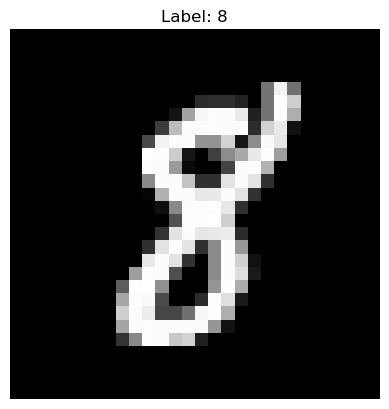

In [12]:
# Ein Beispielbild aus dem Trainingsdatensatz anzeigen
image, label = mnist_train[41]
print(f"Label: {label}")
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## Adversarial Attack (White-Box) durchführen



In diesem Abschnitt werden Adversarial Samples kreiiert und erklärt, weshalb diese funktionieren. Es wird ein vollständiges Beispiel zur **Fast Gradient Sign Method (FGSM)** vorgestellt.

### Aufgabe 1:
1. Warum ist es aus Ihrer Sicht problematisch, wenn ein Modell durch sehr kleine Bildveränderungen falsch klassifiziert? Nennen Sie ein konkretes Beispiel aus dem Alltag, wo eine falsche Bilderkennung schwere Folgen haben kann.
> Ein Beispiel wäre, das autonome Fahren. Wenn ein Auto ein Stop-Schild oder ein Schild mit Tempo-Limite falsch erkennt, kann das autonome Fahrzeug deshalb falsche Entscheidungen treffen.

### Modell Trainieren oder Laden

In [13]:
# Damit wir die Bilder in einem CNN verwenden können, müssen wir die Bilder in Tensoren umwandeln.

transform = torchvision.transforms.ToTensor()

# Mit der Bibliothek Torchvision können wird das MNIST Dataset direkt herunterladen und in einem Schritt in Tensoren umwandeln. 
# Train=True lädt den Trainingsdatensatz, Train=False lädt den Testdatensatz.
mnist_transformed_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=transform)
mnist_transformed_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_transformed_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_transformed_test, batch_size=64, shuffle=True)

In [69]:
### Modell Laden oder Trainieren

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*5*5, out_features=10),
)

# Testen ob das Modell in einer Datei bereits vorhanden ist, wenn ja, laden wir die Gewichte, ansonsten trainieren wir das Modell neu
if os.path.exists("mnist_cnn.pth"):
	model.load_state_dict(torch.load("mnist_cnn.pth", map_location=device))
	print("Modell erfolgreich geladen!")
else:
    print("Das Modell wurde nicht gefunden, wir trainieren es neu...")

    # Hyperparameter definieren
    max_num_epochs = 5
    learning_rate = 0.001
    momentum = 0.9

    # Optimizer und die Loss-Funktion definieren
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    loss = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    # Das Modell muss noch auf die Hardware verschoben werden.
    model.to(device)

    for epoch in range(max_num_epochs):
        batch_train_losses = []
        for batch in train_loader:
            images, labels = batch

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            train_loss = loss(outputs, labels)
            train_loss.backward()
            optimizer.step()
            batch_train_losses.append(train_loss.item())

        training_loss = np.mean(batch_train_losses)
        train_losses.append(training_loss)

        print(f"Epoch {epoch}: Train Loss = {training_loss:.5f}")

    # Modell speichern
    torch.save(model.state_dict(), 'mnist_cnn.pth')

Das Modell wurde nicht gefunden, wir trainieren es neu...
Epoch 0: Train Loss = 0.87032
Epoch 1: Train Loss = 0.27594
Epoch 2: Train Loss = 0.18501
Epoch 3: Train Loss = 0.14185
Epoch 4: Train Loss = 0.11777


### Fast Gradient Sign Method (FGSM)
Die FGSM nutzt den Gradienten der Verlustfunktion, um eine kleine Störung zu erzeugen, die die Vorhersage stark beeinflusst.

Formel (untargeted):
$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x \mathcal{L}(\theta, x, y))$$

- $x$ ist das Originalbild
- $y$ ist das echte Label
- $\epsilon$ ist die Störstärke (klein!)
- $\mathcal{L}$ ist die Loss-Funktion

#### Verständnisfrage 2
Warum reicht das **Vorzeichen** des Gradienten (sign) aus, anstatt den exakten Gradientenwert zu verwenden?

In [113]:
loss_fn = torch.nn.CrossEntropyLoss()

# Beispielbild auswählen
sample_index = 6
orig_pil, orig_label = mnist_test[sample_index]
orig_tensor = transform(orig_pil).unsqueeze(0).to(device)
label_tensor = torch.tensor([orig_label], device=device)

# Vorhersage des Modells erhalten
def predict_label(model, x):
	with torch.no_grad():
		logits = model(x)
		pred = int(torch.argmax(logits, dim=1).item())
	return pred, logits

# FGSM-Angriff ausführen
def fgsm_attack(model, x, y, epsilon, targeted=False, target_label=None):
	x_adv = x.clone().detach().requires_grad_(True)
	logits = model(x_adv)

	if targeted:
		if target_label is None:
			raise ValueError("target_label muss gesetzt sein.")
		target = torch.tensor([target_label], device=x.device)
		loss = loss_fn(logits, target)
		grad = torch.autograd.grad(loss, x_adv)[0].sign()
		x_adv = x_adv - epsilon * grad
	else:
		loss = loss_fn(logits, y)
		grad = torch.autograd.grad(loss, x_adv)[0].sign()
		x_adv = x_adv + epsilon * grad

	x_adv = torch.clamp(x_adv, 0, 1).detach()
	return x_adv

orig_pred, _ = predict_label(model, orig_tensor)
print(f"Original-Label: {orig_label}, Modell-Vorhersage: {orig_pred}")

# Untargeted FGSM: Wir erhöhen epsilon, bis das Modell falsch klassifiziert
epsilons = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
adv_tensor = orig_tensor
adv_pred = orig_pred
used_eps = 0.0

for eps in epsilons:
	candidate = fgsm_attack(model, orig_tensor, label_tensor, eps, targeted=False)
	pred, _ = predict_label(model, candidate)
	if pred != orig_label:
		adv_tensor = candidate
		adv_pred = pred
		used_eps = eps
		break

print(f"Untargeted: epsilon={used_eps}, adversarial Vorhersage: {adv_pred}")

Original-Label: 4, Modell-Vorhersage: 4
Untargeted: epsilon=0.15, adversarial Vorhersage: 8


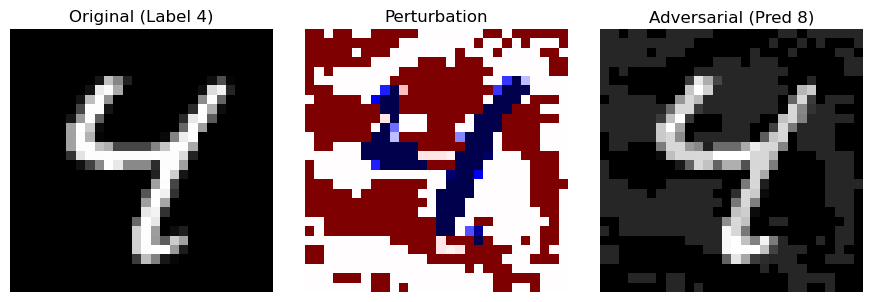

In [114]:
# Visualisierung: Original, Perturbation, Adversarial
orig_img = orig_tensor.squeeze().detach().cpu().numpy()
adv_img = adv_tensor.squeeze().detach().cpu().numpy()
perturbation = (adv_tensor - orig_tensor).squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(orig_img, cmap="gray")
axes[0].set_title(f"Original (Label {orig_label})")
axes[0].axis("off")

axes[1].imshow(perturbation, cmap="seismic")
axes[1].set_title("Perturbation")
axes[1].axis("off")

axes[2].imshow(adv_img, cmap="gray")
axes[2].set_title(f"Adversarial (Pred {adv_pred})")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Targeted vs. Untargeted Attacks
- **Untargeted Attack:** Das Modell soll *irgendeine* falsche Klasse vorhersagen.
- **Targeted Attack:** Das Modell soll *eine ganz bestimmte* falsche Klasse vorhersagen.

Im targeted Fall verändern wir das Bild so, dass die Loss für das Ziel-Label **kleiner** wird (also in Richtung des Ziel-Labels „optimiert“ wird).

Targeted erfolgreich: Ziel=8, epsilon=0.1, Vorhersage: 8


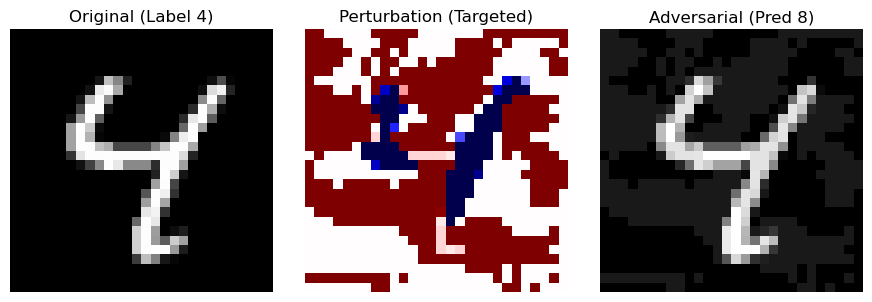

In [121]:
# Targeted FGSM: Wir wollen eine gezielte Zielklasse erzwingen
target_label = 8

target_adv = None
target_pred = None
target_eps = 0.0
best_confidence = 0.0

# Erweiterte Epsilon-Liste für gezielten Angriff
extended_epsilons = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for eps in extended_epsilons:
	candidate = fgsm_attack(
		model,
		orig_tensor,
		label_tensor,
		eps,
		targeted=True,
		target_label=target_label,
	)
	pred, logits = predict_label(model, candidate)
	
	# Berechne die Konfidenz für die Zielklasse
	confidence = torch.softmax(logits, dim=1)[0, target_label].item()
	
	# Speichere die beste Annäherung
	if target_adv is None or confidence > best_confidence:
		target_adv = candidate
		target_pred = pred
		target_eps = eps
		best_confidence = confidence
	
	# Breche ab, wenn das Ziel erreicht wurde
	if pred == target_label:
		break

if target_pred == target_label:
	print(f"Targeted erfolgreich: Ziel={target_label}, epsilon={target_eps}, Vorhersage: {target_pred}")
else:
	print(f"Targeted nicht vollständig erreicht:")
	print(f"  Ziel-Label: {target_label}")
	print(f"  Beste Vorhersage: {target_pred}")
	print(f"  Confidence für Ziel: {best_confidence:.4f}")
	print(f"  Verwendetes epsilon: {target_eps}")

target_adv_img = target_adv.squeeze().detach().cpu().numpy()
target_perturbation = (target_adv - orig_tensor).squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(orig_img, cmap="gray")
axes[0].set_title(f"Original (Label {orig_label})")
axes[0].axis("off")

axes[1].imshow(target_perturbation, cmap="seismic")
axes[1].set_title("Perturbation (Targeted)")
axes[1].axis("off")

axes[2].imshow(target_adv_img, cmap="gray")
axes[2].set_title(f"Adversarial (Pred {target_pred})")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Verständnisfrage 3


## Fast Gradient Value Method (FGV) - Erweiterung

### Unterschied zwischen FGSM und FGV

Bei der **FGSM** nutzen wir nur das **Vorzeichen** des Gradienten:
$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x \mathcal{L})$$

Bei der **FGV (Fast Gradient Value)** nutzen wir den **echten Gradientenwert**, skaliert mit einer Lernrate:
$$x_{adv} = x + \alpha \cdot \nabla_x \mathcal{L}$$

wobei $\alpha$ eine Lernrate ist (ähnlich wie beim Training).

**Vorteile von FGV:**
- Feinere Kontrolle über die Störstärke
- Der Gradient zeigt direkt in die Richtung, die die Loss maximiert
- Kann effizienter sein, erfordert aber unter Umständen kleinere Schrittgrössen

#### Verständnisfrage 4
Warum könnte FGV in manchen Fällen weniger stabil sein als FGSM, wenn man die gleiche Schrittgrösse verwendet?


In [ ]:
def fgv_attack(model, x, y, learning_rate, targeted=False, target_label=None, num_steps=1):
	"""
	Fast Gradient Value Attack: Nutzt den echten Gradientenwert, nicht nur das Vorzeichen.
	
	Args:
		model: Das Klassifizierungsmodell
		x: Input-Tensor (Bild)
		y: Ground-truth Label
		learning_rate: Schrittgrösse (alpha)
		targeted: Boolean für targeted/untargeted
		target_label: Zielklasse (nur bei targeted)
		num_steps: Anzahl der Iterationen
	"""
	x_adv = x.clone().detach()
	
	for step in range(num_steps):
		x_adv_var = x_adv.clone().detach().requires_grad_(True)
		logits = model(x_adv_var)
		
		if targeted:
			if target_label is None:
				raise ValueError("target_label muss gesetzt sein.")
			target = torch.tensor([target_label], device=x.device)
			loss = loss_fn(logits, target)
			grad = torch.autograd.grad(loss, x_adv_var)[0]
			x_adv = x_adv - learning_rate * grad  # Gradienten-Richtung reduzieren
		else:
			loss = loss_fn(logits, y)
			grad = torch.autograd.grad(loss, x_adv_var)[0]
			x_adv = x_adv + learning_rate * grad  # Gradienten-Richtung verstärken
		
		x_adv = torch.clamp(x_adv, 0, 1).detach()
	
	return x_adv

# Test: Untargeted FGV Attack mit erweiterten Learning Rates
# WICHTIG: Die Learning Rates müssen viel grösser sein als bei FGSM, 
# da der echte Gradient oft kleinere Magnituden hat!
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
fgv_adv = None
fgv_pred = orig_pred
used_lr = 0.0
fgv_best_confidence = 1.0  # Initiale Konfidenz für falsches Label

for lr in learning_rates:
	candidate = fgv_attack(model, orig_tensor, label_tensor, learning_rate=lr, targeted=False, num_steps=1)
	pred, logits = predict_label(model, candidate)
	
	# Berechne die Konfidenz für die falsche Klasse (je niedriger für correctes Label, desto besser)
	correct_class_confidence = torch.softmax(logits, dim=1)[0, orig_label].item()
	
	if fgv_adv is None or correct_class_confidence < fgv_best_confidence:
		fgv_adv = candidate
		fgv_pred = pred
		used_lr = lr
		fgv_best_confidence = correct_class_confidence
	
	# Breche ab, wenn das Modell falsch klassifiziert
	if pred != orig_label:
		break

if fgv_pred != orig_label:
	print(f"✓ FGV (Untargeted): learning_rate={used_lr}, Vorhersage: {fgv_pred}")
else:
	print(f"⚠ FGV (Untargeted) nicht erfolgreich:")
	print(f"  Beste Vorhersage: {fgv_pred}")
	print(f"  Konfidenz für Original-Label: {fgv_best_confidence:.4f}")
	print(f"  Verwendete learning_rate: {used_lr}")

print(f"Zum Vergleich - FGSM (Untargeted): epsilon={used_eps}, Vorhersage: {adv_pred}")


✓ FGV (Untargeted): learning_rate=100.0, Vorhersage: 9
Zum Vergleich - FGSM (Untargeted): epsilon=0.15, Vorhersage: 8


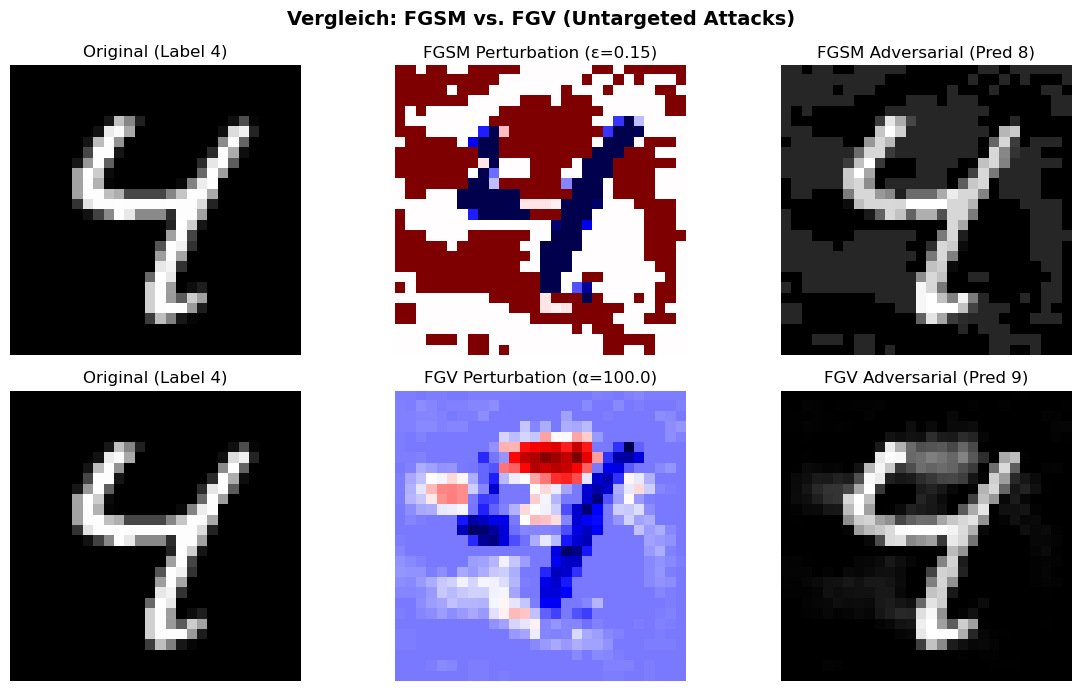


Perturbations-Statistik:
FGSM - Min: -0.1500, Max: 0.1500, Mean Abs: 0.0823
FGV  - Min: -0.3020, Max: 0.5119, Mean Abs: 0.0419


In [123]:
# Visualisierung: FGV vs FGSM (Untargeted)
fgv_img = fgv_adv.squeeze().detach().cpu().numpy()
fgv_perturbation = (fgv_adv - orig_tensor).squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 7))

# Erste Reihe: FGSM
axes[0, 0].imshow(orig_img, cmap="gray")
axes[0, 0].set_title(f"Original (Label {orig_label})")
axes[0, 0].axis("off")

axes[0, 1].imshow(perturbation, cmap="seismic")
axes[0, 1].set_title(f"FGSM Perturbation (ε={used_eps})")
axes[0, 1].axis("off")

axes[0, 2].imshow(adv_img, cmap="gray")
axes[0, 2].set_title(f"FGSM Adversarial (Pred {adv_pred})")
axes[0, 2].axis("off")

# Zweite Reihe: FGV
axes[1, 0].imshow(orig_img, cmap="gray")
axes[1, 0].set_title(f"Original (Label {orig_label})")
axes[1, 0].axis("off")

axes[1, 1].imshow(fgv_perturbation, cmap="seismic")
axes[1, 1].set_title(f"FGV Perturbation (α={used_lr})")
axes[1, 1].axis("off")

axes[1, 2].imshow(fgv_img, cmap="gray")
axes[1, 2].set_title(f"FGV Adversarial (Pred {fgv_pred})")
axes[1, 2].axis("off")

plt.suptitle("Vergleich: FGSM vs. FGV (Untargeted Attacks)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Vergleich der Perturbations-Stärke
print(f"\nPerturbations-Statistik:")
print(f"FGSM - Min: {perturbation.min():.4f}, Max: {perturbation.max():.4f}, Mean Abs: {np.abs(perturbation).mean():.4f}")
print(f"FGV  - Min: {fgv_perturbation.min():.4f}, Max: {fgv_perturbation.max():.4f}, Mean Abs: {np.abs(fgv_perturbation).mean():.4f}")


In [124]:
# Targeted FGV Attack
fgv_target_adv = None
fgv_target_pred = None
fgv_target_lr = 0.0
fgv_best_confidence = 0.0

extended_lrs = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

for lr in extended_lrs:
	candidate = fgv_attack(
		model,
		orig_tensor,
		label_tensor,
		learning_rate=lr,
		targeted=True,
		target_label=target_label,
		num_steps=1
	)
	pred, logits = predict_label(model, candidate)
	confidence = torch.softmax(logits, dim=1)[0, target_label].item()
	
	if fgv_target_adv is None or confidence > fgv_best_confidence:
		fgv_target_adv = candidate
		fgv_target_pred = pred
		fgv_target_lr = lr
		fgv_best_confidence = confidence
	
	if pred == target_label:
		break

if fgv_target_pred == target_label:
	print(f"FGV Targeted erfolgreich: Ziel={target_label}, α={fgv_target_lr}, Vorhersage: {fgv_target_pred}")
else:
	print(f"GV Targeted nicht vollständig erreicht:")
	print(f"  Ziel-Label: {target_label}")
	print(f"  Beste Vorhersage: {fgv_target_pred}")
	print(f"  Konfidenz für Ziel: {fgv_best_confidence:.4f}")
	print(f"  Verwendete learning_rate: {fgv_target_lr}")

fgv_target_img = fgv_target_adv.squeeze().detach().cpu().numpy()
fgv_target_perturbation = (fgv_target_adv - orig_tensor).squeeze().detach().cpu().numpy()


FGV Targeted erfolgreich: Ziel=8, α=0.5, Vorhersage: 8


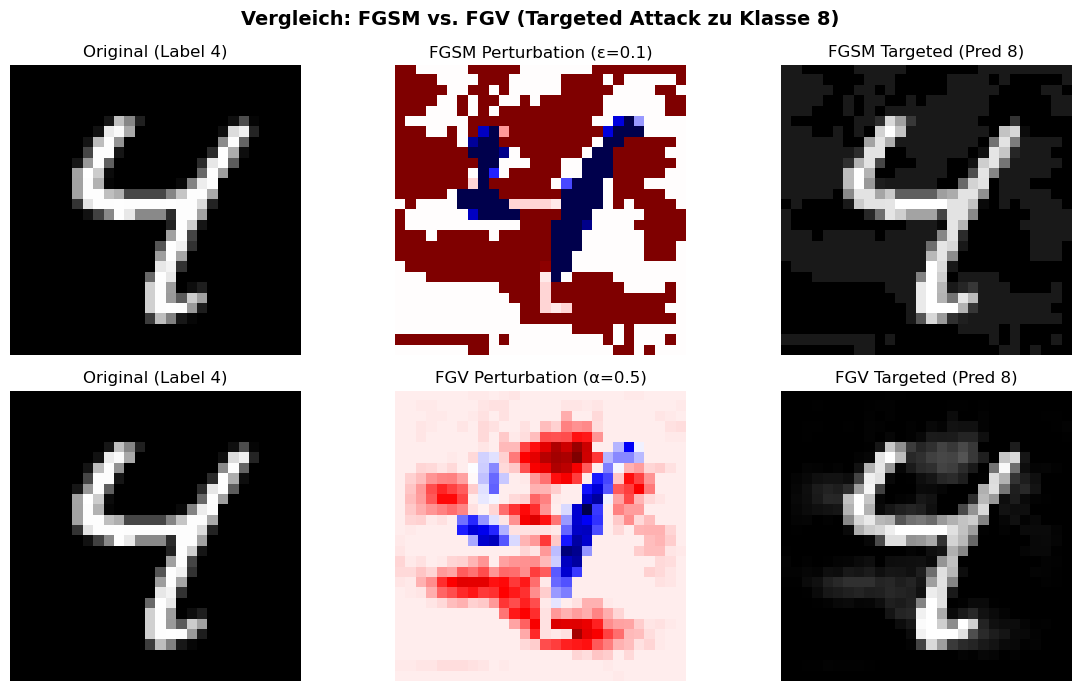


Perturbations-Statistik (Targeted):
FGSM - Min: -0.1000, Max: 0.1000, Mean Abs: 0.0589
FGV  - Min: -0.3502, Max: 0.3283, Mean Abs: 0.0402


In [125]:
# Visualisierung: FGV vs FGSM (Targeted)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

# Erste Reihe: FGSM Targeted
axes[0, 0].imshow(orig_img, cmap="gray")
axes[0, 0].set_title(f"Original (Label {orig_label})")
axes[0, 0].axis("off")

axes[0, 1].imshow(target_perturbation, cmap="seismic")
axes[0, 1].set_title(f"FGSM Perturbation (ε={target_eps})")
axes[0, 1].axis("off")

axes[0, 2].imshow(target_adv_img, cmap="gray")
axes[0, 2].set_title(f"FGSM Targeted (Pred {target_pred})")
axes[0, 2].axis("off")

# Zweite Reihe: FGV Targeted
axes[1, 0].imshow(orig_img, cmap="gray")
axes[1, 0].set_title(f"Original (Label {orig_label})")
axes[1, 0].axis("off")

axes[1, 1].imshow(fgv_target_perturbation, cmap="seismic")
axes[1, 1].set_title(f"FGV Perturbation (α={fgv_target_lr})")
axes[1, 1].axis("off")

axes[1, 2].imshow(fgv_target_img, cmap="gray")
axes[1, 2].set_title(f"FGV Targeted (Pred {fgv_target_pred})")
axes[1, 2].axis("off")

plt.suptitle(f"Vergleich: FGSM vs. FGV (Targeted Attack zu Klasse {target_label})", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"\nPerturbations-Statistik (Targeted):")
print(f"FGSM - Min: {target_perturbation.min():.4f}, Max: {target_perturbation.max():.4f}, Mean Abs: {np.abs(target_perturbation).mean():.4f}")
print(f"FGV  - Min: {fgv_target_perturbation.min():.4f}, Max: {fgv_target_perturbation.max():.4f}, Mean Abs: {np.abs(fgv_target_perturbation).mean():.4f}")


### Zusammenfassung: FGSM vs. FGV

#### Charakteristiken der beiden Methoden

| Eigenschaft | FGSM | FGV |
|---|---|---|
| **Gradientenutzung** | Nur Vorzeichen: $\text{sign}(\nabla)$ | Echter Wert: $\nabla$ |
| **Schrittgrösse** | Epsilon ($\epsilon$), einheitlich | Lernrate ($\alpha$), variabel |
| **Perturbation-Grösse** | Gleichmässig begrenzt | Abhängig von Gradientenmagnitude |
| **Berechnung** | 1 Schritt, sehr einfach | Iterativ (meist 1 Schritt) |
| **Stabilität** | Robust, vorhersagbar | Kann überschiessen |
| **Effizienz** | Schnell, minimal | Kann feinere Kontrolle bieten |

#### Verständnisfrage 5
Basierend auf den Visualisierungen: Welche Methode erzeugt stärkere Perturbationen bei vergleichbarem Erfolg?

#### Verständnisfrage 6
Warum könnte die FGV-Methode bei iterativen Angreifern (mehrere Schritte) sinnvoll sein, aber bei Einschritt-Angriffen möglicherweise nicht optimal?
